In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R
from scipy.spatial import KDTree
from orix.quaternion import Orientation, symmetry, Rotation
from orix.sampling import get_sample_fundamental
from orix.vector import Vector3d, Homochoric
from orix.io import load
from math import pi

In [2]:
pg432 = symmetry.O
pg622 = symmetry.get_point_group(180)

# if 'acc' in globals() is False:
print("making new accumulator")
full_accumulator = get_sample_fundamental(2, point_group=pg432, method="cubochoric")

homoArr = Homochoric.from_rotation(full_accumulator).data
tree = KDTree(homoArr)

# need to transform this accumulator into Homochoric axis/angle

# need to run KD Tree on this cloud of points: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.html

# need to try reading in some rando ebsd file, grab all the orientations,

# and use KD tree to RAPIDLY find all their nearest neighbors

making new accumulator


In [3]:
ebsdFile = 'AF_110.ang'
xMap = load(ebsdFile)
print(xMap)

xMap_homo_arr = Homochoric.from_rotation(xMap.rotations).data
distance, pairs = tree.query(xMap_homo_arr)
unique, counts = np.unique(pairs, return_counts=True)

Phase     Orientations          Name  Space group  Point group  Proper point group       Color
    1       912 (0.9%)  b'Austenite'         None          432                 432  tab:orange
    2   102129 (99.1%)   b'\x80\xbf'         None          432                 432    tab:blue
Properties: iq, ci, unknown1, fit, unknown2, unknown3, unknown4, unknown5
Scan unit: um


In [4]:
full_accum_counts = np.zeros((full_accumulator.shape))
full_accum_counts[unique] = counts

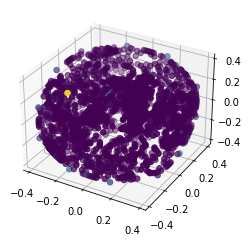

In [5]:
uniqueHomo = homoArr[unique]
fig = plt.figure()
ax3D = fig.add_subplot(111, projection='3d')
p3d = ax3D.scatter(uniqueHomo[:,0], uniqueHomo[:,1], uniqueHomo[:,2], s=30, c=counts, marker='o')

In [6]:
print(np.mean(full_accum_counts), np.max(full_accum_counts))
full_accum_counts_normed = full_accum_counts*2*pi*len(full_accum_counts)/np.sum(full_accum_counts)
print(np.mean(full_accum_counts_normed), np.max(full_accum_counts_normed))

1.0268468414601333 7382.0
6.283185307179585 45169.80728269638


In [7]:
accum_counts_normed = counts*2*pi*len(counts)/np.sum(counts)
print(np.mean(accum_counts_normed), np.max(accum_counts_normed))

6.283185307179587 1250.4780873502002


In [8]:
accumulator = full_accumulator[unique]
print(accumulator[0])

euler_accum = accumulator.to_euler()
print(euler_accum[0])

Rotation (1,)
[[ 0.8541 -0.3536 -0.3536 -0.1435]]
[0.95180882 1.04721856 5.6641978 ]


In [10]:
from calc_wigner_d import calc_Wigner_D, stack_all_precalc_terms

In [11]:
l = 32 ### bandwidth value
# vector_length = np.sum([(2*cL+1)**2 for cL in np.arange(1,l+1)])
terms = stack_all_precalc_terms(l)
D_LMN_R = np.zeros((len(euler_accum), len(terms[0])), dtype=np.complex_)

for i, rot in enumerate(euler_accum):
    D_LMN_R[i] = calc_Wigner_D(rot[0], rot[1], rot[2], terms)

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [17]:
c_lmn = np.zeros((len(euler_accum), len(terms[0])), dtype=np.complex_)

for i, fWeight in enumerate(accum_counts_normed):

    c_lmn[i] = (2*terms[7][i]+1)/(8*(pi**2))*fWeight*np.conjugate(D_LMN_R[i])


In [18]:
full_euler_accumulator = full_accumulator.to_euler()
# full_accum_counts_normed
full_c_lmn = np.zeros((len(full_euler_accumulator), len(terms[0])), dtype=np.complex_)
full_c_lmn[unique] = c_lmn